In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import time
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = "/content/drive/MyDrive/Code/cv/cifar10/Data"

# Chuẩn bị data

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
  root=data,
  train=True,
  download=True,
  transform=transforms.ToTensor()
)


train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=256,
  shuffle=False,
  num_workers=2
)

Files already downloaded and verified


In [4]:
next(iter(train_loader))

[tensor([[[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
           [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
           [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
           ...,
           [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
           [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
           [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
          [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
           [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
           [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
           ...,
           [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
           [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
           [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
          [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
           [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
           [0.0824, 0.00

In [5]:
mean = 0.0
std = 0.0
nb_samples = 0

for data in train_loader:
  images, _ = data
  batch_samples = images.size(0)
  images = images.view(batch_samples, images.size(1), -1)
  mean += images.mean(2).sum(0)
  std += images.std(2).sum(0)
  nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2023, 0.1994, 0.2010])


In [6]:
data = "/content/drive/MyDrive/Code/cv/cifar10/Data"
transfrom_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root=data, train=True, download=True, transform=transfrom_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, num_workers=10, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=data, train=False, download=True, transform=transfrom_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, num_workers=10, shuffle=False)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


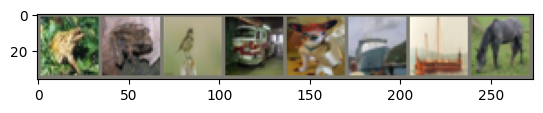

(None, torch.Size([256, 3, 32, 32]))

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img*torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

images, _ = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images[:8])), images.shape

#build model

## Build model CNN

In [ ]:
class Cnn(nn.Module):
  def __init__(self):
    super(Cnn, self).__init__() # input (3, 32, 32)
    self.conv1 = nn.Conv2d(3, 16, 3) # 16, 30, 30
    self.conv2 = nn.Conv2d(16, 32, 3) # 32, 28, 28 pooling 32, 14, 14
    self.conv3 = nn.Conv2d(32, 64, 3) # 64, 12, 12
    self.conv4 = nn.Conv2d(64, 128, 3) # 128, 10, 10
    self.conv5 = nn.Conv2d(128, 256, 3) # 256, 8, 8 pooling 256, 4, 4
    self.conv6 = nn.Conv2d(256, 512, 3) # 512, 2, 2
    self.pool = nn.MaxPool2d(2, 2)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(512*2*2, 10)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))
    x = self.pool(self.relu(self.conv5(x)))
    x = self.relu(self.conv6(x))
    x = self.flatten(x)
    x = self.fc(x)
    return x


In [ ]:
import torchsummary
model = Cnn()
model.to(device)
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 12, 12]          18,496
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8          [-1, 128, 10, 10]          73,856
              ReLU-9          [-1, 128, 10, 10]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 2, 2]       1,180,160
             ReLU-14            [-1, 51

In [ ]:
# model.train()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# for idx, (images, labels) in enumerate(trainloader):
#   images, labels = images.to(device), labels.to(device)
#   optimizer.zero_grad()
#   outputs = model(images)
#   loss = criterion(outputs, labels)
#   loss.backward()
#   optimizer.step()
#   print(loss.item())

In [ ]:
def train_epoch(model, trainloader, optimizer, criterion, device, epoch=0, log_interval=-1):
  model.train()
  total_acc, total_count = 0, 0
  losses = []
  start_time = time.time()

  for idx, (images, labels) in enumerate(trainloader):
    if log_interval == -1:
      log_interval = len(trainloader) / 4
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    total_acc += (outputs.argmax(1) == labels).sum().item()
    total_count += labels.size(0)
    if idx % log_interval == 0:
      elapsed = time.time() - start_time
      print("| epoch {:4d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(
              epoch, idx, len(trainloader), total_acc / total_count * 100
          ))
      total_acc, total_count = 0, 0
      start_time = time.time()
  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [ ]:
def evaluate(model, test_loader, criterion, device):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []
  with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      total_acc += (outputs.argmax(1) == labels).sum().item()
      total_count += labels.size(0)
  epoch_acc = total_acc / total_count * 100
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [ ]:
def train(model, optimizer, criterion, trainloader, testloader, epochs, device):
  train_losses, train_accs = [], []
  eval_losses, eval_accs = [], []
  times = []
  epoch_start_time = time.time()
  for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, trainloader, optimizer, criterion, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    eval_acc, eval_loss = evaluate(model, testloader, criterion, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)
    times.append(time.time() - epoch_start_time)
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)
  metrics = {
    'train_accuracy': train_accs,
    'train_loss': train_losses,
    'valid_accuracy': eval_accs,
    'valid_loss': eval_losses,
    'time': times
  }
  return model, metrics

In [ ]:
model = Cnn()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.to(device)
model, metrics = train(model, optimizer, criterion, trainloader, testloader, 20, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


| epoch    0 |     0/  196 batches | accuracy    9.375
| epoch    0 |    49/  196 batches | accuracy   26.722
| epoch    0 |    98/  196 batches | accuracy   36.105
| epoch    0 |   147/  196 batches | accuracy   42.419
-----------------------------------------------------------
| End of epoch   0 | Time: 19.98s | Train Accuracy    0.467 | Train Loss    1.673 | Valid Accuracy   48.690 | Valid Loss    1.397 
-----------------------------------------------------------
| epoch    1 |     0/  196 batches | accuracy   47.266
| epoch    1 |    49/  196 batches | accuracy   50.558
| epoch    1 |    98/  196 batches | accuracy   52.503
| epoch    1 |   147/  196 batches | accuracy   56.768
-----------------------------------------------------------
| End of epoch   1 | Time: 37.61s | Train Accuracy    0.576 | Train Loss    1.259 | Valid Accuracy   59.030 | Valid Loss    1.148 
-----------------------------------------------------------
| epoch    2 |     0/  196 batches | accuracy   61.328
| e

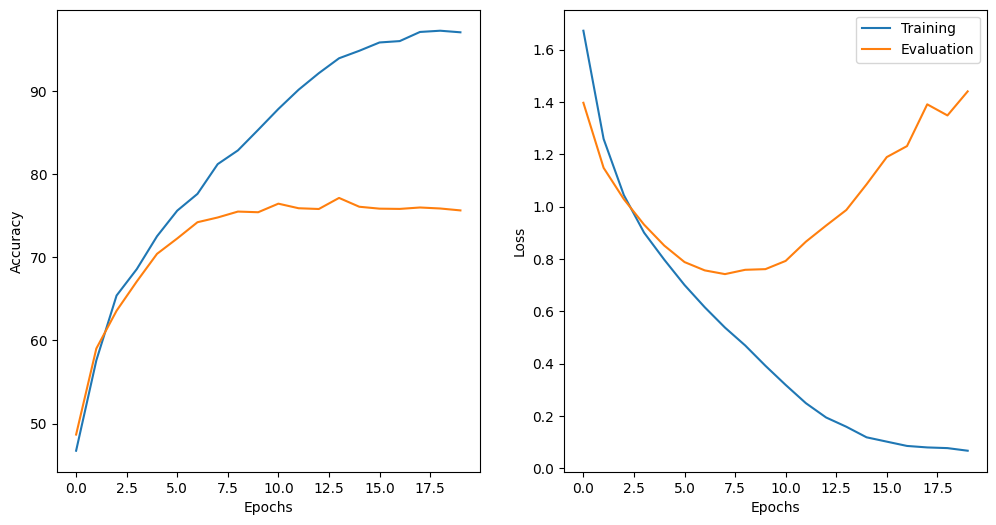

In [ ]:
import matplotlib.pyplot as plt
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()
metrics_accs = [x * 100 for x in metrics["train_accuracy"]]
plot_result(
    20,
    metrics_accs,
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

# Optimizer and use vgg16
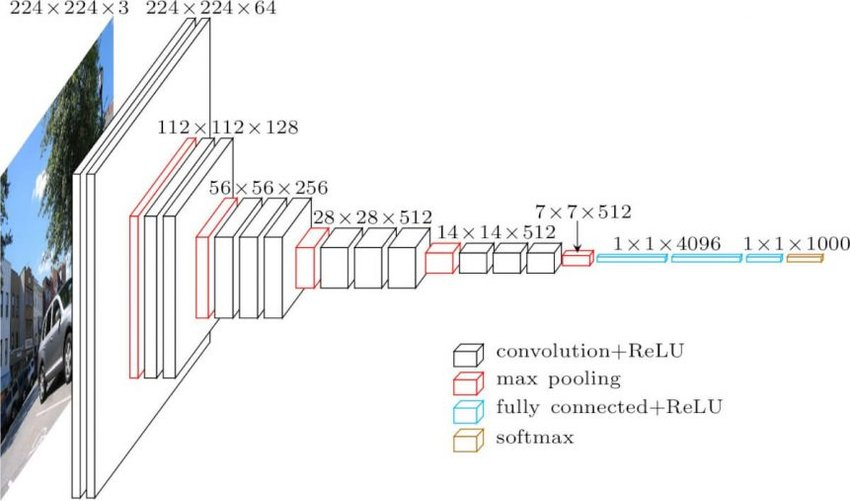

## Build Vgg16 use he intialization, batchnormal, ship connection, dropout

In [8]:
class Vgg16(nn.Module):
  def __init__(self):
    super(Vgg16, self).__init__() # input(256, 3, 32, 32)
    #Block_1 output(256, 64, 16, 16)
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64))
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64, 64, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.3))
    self.skip1 = nn.Sequential(
        nn.Conv2d(3, 64, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64))

    #Block_2 output(256, 128, 8, 8)
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128))
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(128, 128, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.3))
    self.skip2 = nn.Sequential(
        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128))

    #Block 3 output(256, 256, 4, 4)
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(128, 256, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256))
    self.conv_layer6 = nn.Sequential(
        nn.Conv2d(256, 256, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256))
    self.conv_layer7 = nn.Sequential(
        nn.Conv2d(256, 256, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.3))
    self.skip3 = nn.Sequential(
        nn.Conv2d(128, 256, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256))

    #Block 4 output(256, 512, 2, 2)
    self.conv_layer8 = nn.Sequential(
        nn.Conv2d(256, 512, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(512))
    self.conv_layer9 = nn.Sequential(
        nn.Conv2d(512, 512, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(512))
    self.conv_layer10 = nn.Sequential(
        nn.Conv2d(512, 512, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.3))
    self.skip4 = nn.Sequential(
        nn.Conv2d(256, 512, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512))

    #Block5 output(256, 1024, 1, 1)
    self.conv_layer11 = nn.Sequential(
          nn.Conv2d(512, 1024, 3, stride=1, padding='same'),
          nn.ReLU(),
          nn.BatchNorm2d(1024))
    self.conv_layer12 = nn.Sequential(
        nn.Conv2d(1024, 1024, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(1024))
    self.conv_layer13 = nn.Sequential(
        nn.Conv2d(1024, 1024, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(1024),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.3))
    self.skip5 = nn.Sequential(
        nn.Conv2d(512, 1024, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(1024))
    # Block fully connected layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Linear(64, 10))

  #   self.initialize_weights()

  # def initialize_weights(self):
  #     for m in self.modules():
  #         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
  #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
  #             if m.bias is not None:
  #                 nn.init.constant_(m.bias, 0)

  def forward(self, x):
        skip = self.skip1(x)
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x + skip

        skip = self.skip2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = x + skip

        skip = self.skip3(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = x + skip

        skip = self.skip4(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = x + skip

        skip = self.skip5(x)
        x = self.conv_layer11(x)
        x = self.conv_layer12(x)
        x = self.conv_layer13(x)
        x = x + skip

        out = self.classifier(x)

        return out


In [9]:
model = Vgg16().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
       BatchNorm2d-3           [-1, 64, 16, 16]             128
            Conv2d-4           [-1, 64, 32, 32]           1,792
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,928
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        MaxPool2d-10           [-1, 64, 16, 16]               0
          Dropout-11           [-1, 64, 16, 16]               0
           Conv2d-12            [-1, 128, 8, 8]          73,856
             ReLU-13            [-1, 128, 8, 8]               0
      BatchNorm2d-14            [-1, 12

## Train với regularization, Adam optimizer, learning rate schedule

In [10]:
def train_epoch_vgg16(model, optimizer, criterion, trainloader, device, epoch=0, log_interval=-1):
  model.train()
  total_acc, total_count = 0, 0
  losses = []
  start_time = time.time()
  for idx, (images, labels) in enumerate(trainloader):
    if log_interval == -1:
      log_interval = len(trainloader) / 4
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    total_acc += (outputs.argmax(1) == labels).sum().item()
    total_count += labels.size(0)
    if idx % log_interval == 0:
      elapsed = time.time() - start_time
      print("| epoch {:4d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(
              epoch, idx, len(trainloader), total_acc / total_count * 100
          ))
      total_acc, total_count = 0, 0
      start_time = time.time()
  epoch_acc = total_acc / total_count * 100
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss



In [11]:
def evaluate_vgg16(model, criterion, testloader, device):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []
  with torch.no_grad():
    for idx, (images, labels) in enumerate(testloader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      losses.append(loss)
      total_acc += (outputs.argmax(1) == labels).sum().item()
      total_count += labels.size(0)
  eval_acc = total_acc / total_count * 100
  eval_loss = sum(losses) / len(losses)
  return eval_acc, eval_loss


In [12]:
def train_vgg16(model, model_name, optimizer, criterion, trainloader, testloader, epochs, device, lr_scheduler, log_interval=-1):
  train_losses, train_accs = [], []
  eval_losses, eval_accs = [], []
  times = []
  best_loss_eval = 100
  epoch_start_time = time.time()
  for epoch in range(epochs):
    train_acc, train_loss = train_epoch_vgg16(model, optimizer, criterion, trainloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    eval_acc, eval_loss = evaluate_vgg16(model, criterion, testloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)
    times.append(time.time() - epoch_start_time)
    #Lưu model tốt nhất
    if eval_loss < best_loss_eval:
      torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
    print("-" * 130)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 130)
    lr_scheduler.step()
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
  metrics = {
    'train_accuracy': train_accs,
    'train_loss': train_losses,
    'valid_accuracy': eval_accs,
    'valid_loss': eval_losses,
    'time': times
  }
  return model, metrics

## Learn heard and data augmentation

In [13]:
transforms_vgg16 = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       transforms.RandomErasing(p=0.5, scale=(0.01, 0.3), ratio = (1, 1), value=0, inplace=True),
                                       transforms.RandomCrop(32, padding=2),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(5)])
trainset_vgg16 = torchvision.datasets.CIFAR10(root=data, train=True, download=True, transform=transforms_vgg16)
trainloader_vgg16 = torch.utils.data.DataLoader(trainset_vgg16, batch_size=256, num_workers=10, shuffle=True)

Files already downloaded and verified


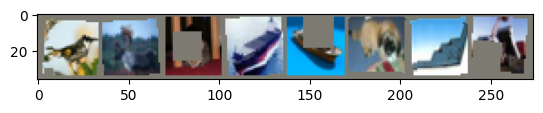

(None, torch.Size([256, 3, 32, 32]))

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img*torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

images, _ = next(iter(trainloader_vgg16))
imshow(torchvision.utils.make_grid(images[:8])), images.shape

## Train model

In [17]:
model = Vgg16().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
decay = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
criterion = nn.CrossEntropyLoss()
save_model = "/content/drive/MyDrive/Code/cv/cifar10/Model"
os.makedirs(save_model, exist_ok = True)
model_name = 'vgg16_model'
model, metrics = train_vgg16(model, model_name, optimizer, criterion, trainloader_vgg16, testloader, epochs=50, device=device, lr_scheduler=lr_scheduler)


| epoch    0 |     0/  196 batches | accuracy   11.719
| epoch    0 |    49/  196 batches | accuracy   30.859
| epoch    0 |    98/  196 batches | accuracy   42.036
| epoch    0 |   147/  196 batches | accuracy   48.605
----------------------------------------------------------------------------------------------------------------------------------
| End of epoch   0 | Time: 62.58s | Train Accuracy   52.312 | Train Loss    1.548 | Valid Accuracy   54.840 | Valid Loss    1.293 
----------------------------------------------------------------------------------------------------------------------------------


<ipython-input-12-f42daafa2487>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


| epoch    1 |     0/  196 batches | accuracy   57.422
| epoch    1 |    49/  196 batches | accuracy   55.692
| epoch    1 |    98/  196 batches | accuracy   59.774
| epoch    1 |   147/  196 batches | accuracy   62.022
----------------------------------------------------------------------------------------------------------------------------------
| End of epoch   1 | Time: 127.13s | Train Accuracy   62.995 | Train Loss    1.124 | Valid Accuracy   69.600 | Valid Loss    0.878 
----------------------------------------------------------------------------------------------------------------------------------
| epoch    2 |     0/  196 batches | accuracy   67.188
| epoch    2 |    49/  196 batches | accuracy   66.303
| epoch    2 |    98/  196 batches | accuracy   67.451
| epoch    2 |   147/  196 batches | accuracy   68.471
----------------------------------------------------------------------------------------------------------------------------------
| End of epoch   2 | Time: 190.56s 

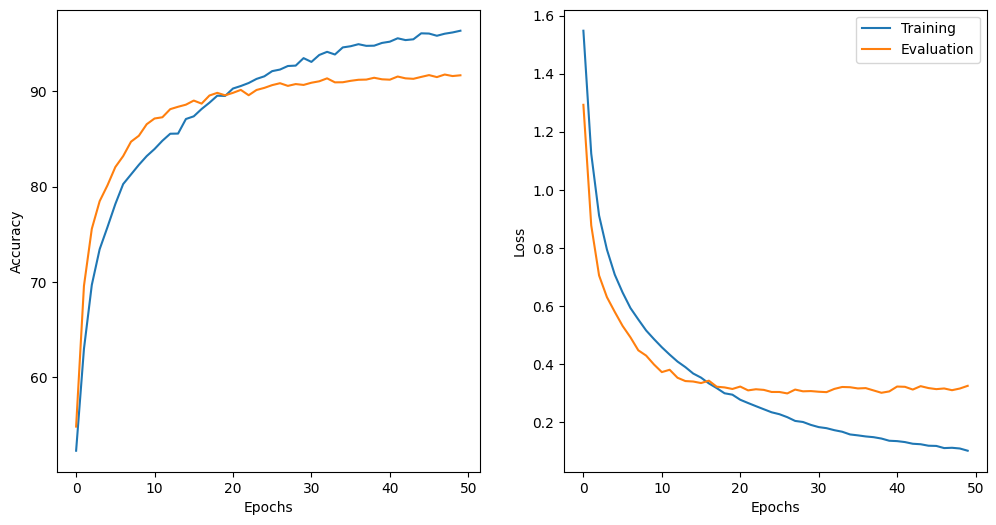

In [29]:
import matplotlib.pyplot as plt
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

def to_cpu_numpy(data):
    return [x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in data]

plot_result(
    50,
    to_cpu_numpy(metrics["train_accuracy"]),
    to_cpu_numpy(metrics["valid_accuracy"]),
    to_cpu_numpy(metrics["train_loss"]),
    to_cpu_numpy(metrics["valid_loss"])
)